A notebook that contains evaluation timeseries and correlation plots that compare data from the ORCA buoy at Point Williams in Main Basin to the model data. The data used are hourly averages of the modeled and observed data. 

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import xarray as xr
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import Keegan_eval_tools as ket
from collections import OrderedDict
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
saveloc='/ocean/kflanaga/MEOPAR/savedData/King_CountyData/hourly_pickle_files'
year=2019
Mooring='PointWilliams'

In [4]:
##### Loading in pickle file data
with open(os.path.join(saveloc,f'hourly_data_{Mooring}_{year}.pkl'),'rb') as hh:
    data=pickle.load(hh)

In [5]:
grid=xr.open_mfdataset(f'/ocean/kflanaga/MEOPAR/savedData/201905_grid_data/ts_HC201905_{year}_{Mooring}.nc')

In [6]:
%%time
tt=grid.time_centered
vot=grid.votemper.isel(deptht=0,y=0,x=0)
vos=grid.vosaline.isel(deptht=0,y=0,x=0)

CPU times: user 2.01 ms, sys: 0 ns, total: 2.01 ms
Wall time: 2.01 ms


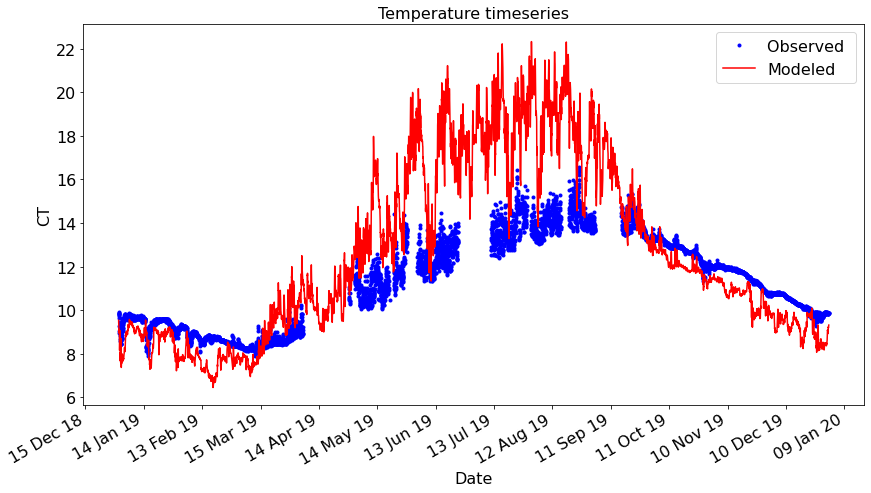

In [7]:
obsvar='CT'
fig,ax=plt.subplots(1,1,figsize=(14,7))

ps=[]
p0,=ax.plot(data['dtUTC'],data[obsvar],'.',color='blue',label=f'Observed ')
ps.append(p0)
p0,=ax.plot(tt,vot,'-',color='red',label='Modeled')
ps.append(p0)
ax.legend(handles=ps)
ax.set_ylabel(f'{obsvar}')
ax.set_xlabel('Date')
ax.set_title('Temperature timeseries')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
M = 15
xticks = mpl.ticker.MaxNLocator(M)
ax.xaxis.set_major_locator(xticks)
yearsFmt = mdates.DateFormatter('%d %b %y')
ax.xaxis.set_major_formatter(yearsFmt)

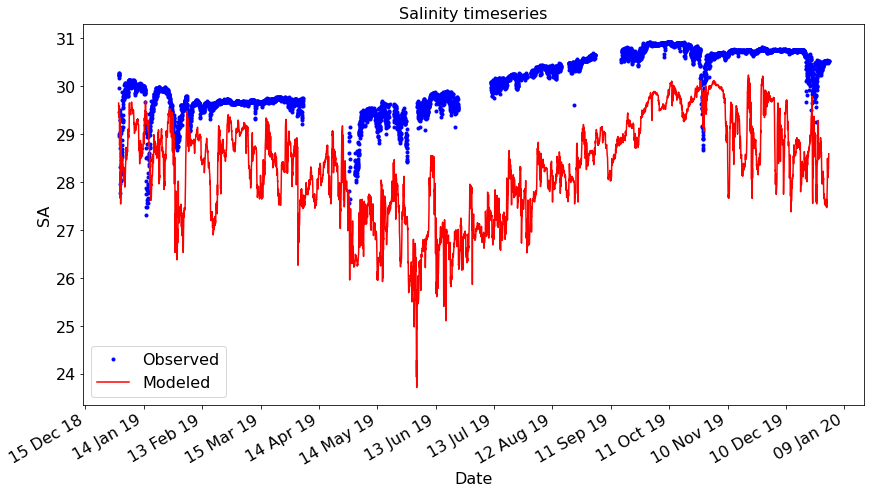

In [8]:
obsvar='SA'
fig,ax=plt.subplots(1,1,figsize=(14,7))

ps=[]
p0,=ax.plot(data['dtUTC'],data[obsvar],'.',color='blue',label=f'Observed')
ps.append(p0)
p0,=ax.plot(tt,vos,'-',color='red',label='Modeled')
ps.append(p0)
ax.legend(handles=ps)
ax.set_ylabel(f'{obsvar}')
ax.set_xlabel('Date')
ax.set_title('Salinity timeseries')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
M = 15
xticks = mpl.ticker.MaxNLocator(M)
ax.xaxis.set_major_locator(xticks)
yearsFmt = mdates.DateFormatter('%d %b %y')
ax.xaxis.set_major_formatter(yearsFmt)

In [9]:
grid.close()

In [10]:
bio=xr.open_mfdataset(f'/ocean/kflanaga/MEOPAR/savedData/201905_ptrc_data/ts_HC201905_{year}_{Mooring}.nc')

In [11]:
ik=0
ij=0
ii=0

In [12]:
%%time
tt=bio.time_counter
mod_nitrate=(bio.nitrate.isel(deptht=ik,y=ij,x=ii))
diatom=bio.diatoms.isel(deptht=ik,y=ij,x=ii)
flagellate=bio.flagellates.isel(deptht=ik,y=ij,x=ii)
ciliate=bio.ciliates.isel(deptht=ik,y=ij,x=ii)
mod_Chl=(diatom+flagellate+ciliate)*1.8

CPU times: user 5.73 ms, sys: 441 µs, total: 6.17 ms
Wall time: 6.07 ms


In [13]:
data.columns

Index(['year_hours', 'Depth_m', 'Qual_Depth', 'Water_Temperature_degC',
       'Qual_Water_Temperature', 'Salinity_PSU', 'Qual_Salinity',
       'Chlorophyll_Fluorescence_ug/L', 'Qual_Chlorophyll_Fluorescence',
       'SUNA_Nitrite+Nitrate_mgN/L_raw_raw',
       'Qual_SUNA_Nitrite+Nitrate_mgN/L_raw_raw',
       'SUNA_Nitrite+Nitrate_mgN/L_raw_final',
       'Qual_SUNA_Nitrite+Nitrate_mgN/L_raw_final', 'Sonde_Batt_V',
       'Logger_Batt_V', 'Lat', 'Lon', 'Z', 'SA', 'CT', 'Chl', 'YD', 'NO23',
       'dtUTC'],
      dtype='object', name=50)

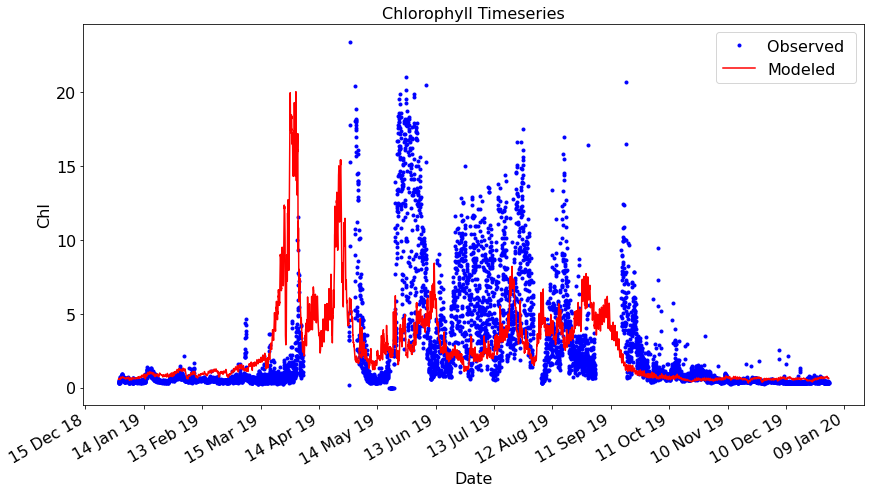

In [14]:
obsvar='Chl'
modvar=mod_Chl
fig,ax=plt.subplots(1,1,figsize=(14,7))

ps=[]
p0,=ax.plot(data['dtUTC'],data[obsvar],'.',color='blue',label=f'Observed ')
ps.append(p0)
p0,=ax.plot(tt,modvar,'-',color='red',label='Modeled')
ps.append(p0)
ax.legend(handles=ps)
ax.set_ylabel(f'{obsvar}')
ax.set_xlabel('Date')
ax.set_title('Chlorophyll Timeseries')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
M = 15
xticks = mpl.ticker.MaxNLocator(M)
ax.xaxis.set_major_locator(xticks)
yearsFmt = mdates.DateFormatter('%d %b %y')
ax.xaxis.set_major_formatter(yearsFmt)

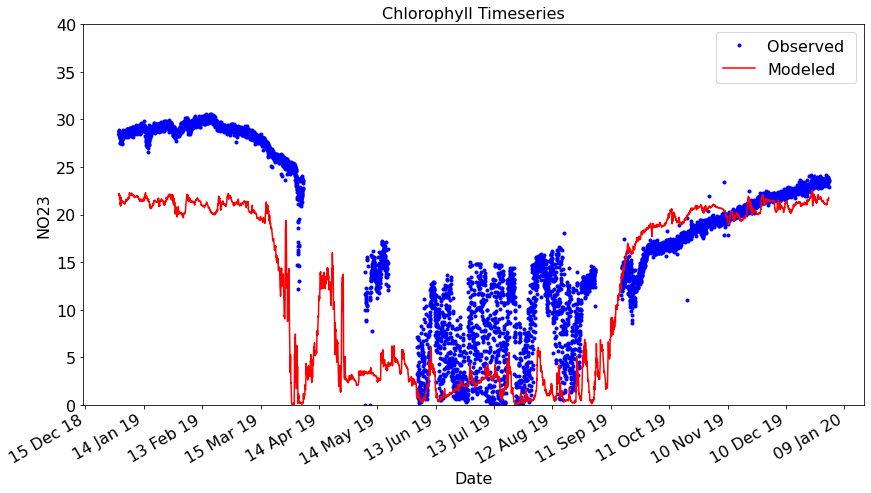

In [15]:
obsvar='NO23'
modvar=mod_nitrate
fig,ax=plt.subplots(1,1,figsize=(14,7))

ps=[]
p0,=ax.plot(data['dtUTC'],data[obsvar],'.',color='blue',label=f'Observed ')
ps.append(p0)
p0,=ax.plot(tt,modvar,'-',color='red',label='Modeled')
ps.append(p0)
ax.legend(handles=ps)
ax.set_ylabel(f'{obsvar}')
ax.set_ylim((0,40))
ax.set_xlabel('Date')
ax.set_title('Chlorophyll Timeseries')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
M = 15
xticks = mpl.ticker.MaxNLocator(M)
ax.xaxis.set_major_locator(xticks)
yearsFmt = mdates.DateFormatter('%d %b %y')
ax.xaxis.set_major_formatter(yearsFmt)